In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
import InsanallyLabEphysTools as ilep
import OldDecodingTools as odt
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from itertools import product
from datetime import datetime
import h5py
#import tables as tb
from copy import deepcopy
import colorsys
import pingouin as pg

from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.neighbors import KernelDensity

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
GOOD_GREY = '#969696'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)

act_directory = 'D:\\Analysis_Cache'
beh_directory = 'P:\\Behavioor'

%run animal_info
ANIMAL = 'AC_12102016'

animalstouse = ['BS_40','BS_41','BS_42','BS_49','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

In [2]:
both = 0
stim = 0
choice = 0
none = 0

for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if not sessionfile.meta.region == 'AC':
        continue
    
    for clust in sessionfile.clusters.good:

        if not hasattr(sessionfile.responsiveness[clust]['all_trials'],'FRmodpval'):
            continue
        if not hasattr(sessionfile.responsiveness[clust]['all_trials'],'FRmodpvalchoice'):
            continue

        stim_sig = False
        choice_sig = False

        if sessionfile.responsiveness[clust]['all_trials'].FRmodpval < 0.05:
            stim_sig = True
        if sessionfile.responsiveness[clust]['all_trials'].FRmodpvalchoice < 0.05:
            choice_sig = True

        if stim_sig and choice_sig:
            both += 1
        elif stim_sig:
            stim += 1
        elif choice_sig:
            choice += 1
        else:
            none += 1

100%|██████████| 398/398 [00:08<00:00, 47.69it/s]


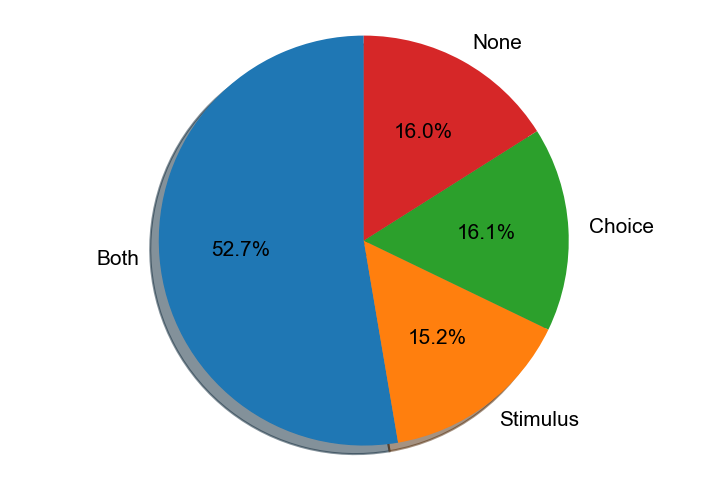

In [5]:
labels = 'Both', 'Stimulus', 'Choice', 'None'
sizes = [both,stim,choice,none]
explode = (0, 0, 0, 0)

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio
fig.savefig(os.path.join('D:\\\\Figures','Population Statistics','Overall population statistics pie chart.pdf'),transparent=False,facecolor="white")

  4%|▍         | 15/398 [00:07<03:16,  1.95it/s]


TypeError: can only concatenate str (not "numpy.float64") to str

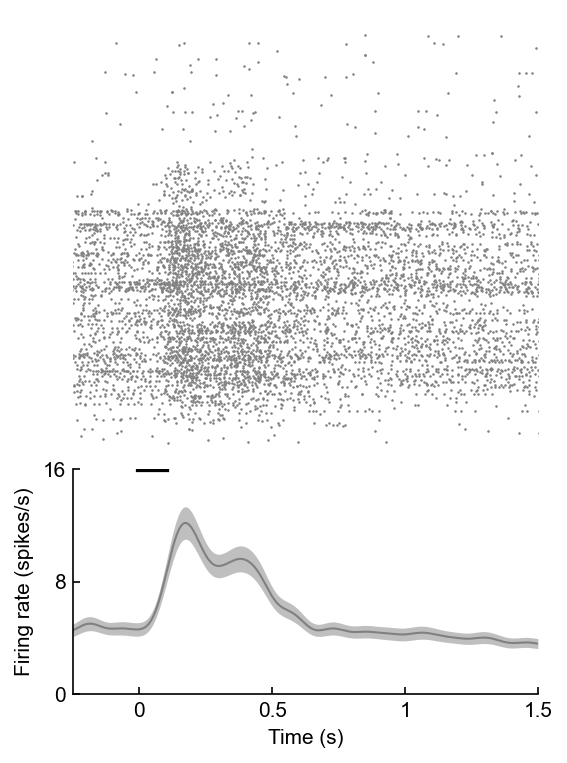

In [8]:
stim_ev = 0
stim_sup = 0
NCR = 0

for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    for clust in sessionfile.clusters.good:
        plt.close('all')

        if not hasattr(sessionfile.responsiveness[clust]['all_trials'],'FRmodpval'):
            continue

        stim_sig = False
        if sessionfile.responsiveness[clust]['all_trials'].FRmodpval < 0.05:
            stim_sig = True
            
        stim_evoked = False
        if sessionfile.responsiveness[clust]['all_trials'].FR > sessionfile.responsiveness[clust]['all_trials'].FRbaseline:
            stim_evoked = True

        if stim_sig and stim_evoked:
            stim_ev += 1
            fig,[ax1,ax2] = ilep.visualizeCluster(sessionfile,clust)
            FRmod = sessionfile.responsiveness[clust]['all_trials'].FR - sessionfile.responsiveness[clust]['all_trials'].FRbaseline
            FR = sessionfile.responsiveness[clust]['all_trials'].FR
            FRbaseline = sessionfile.responsiveness[clust]['all_trials'].FRbaseline
            ax1.set_title('p = '+str(sessionfile.responsiveness[clust]['all_trials'].FRmodpval)+'\nFRmod = '+str(FRmod)+'\nFR = '+str(FR)+'\nFRbaseline = '+FRbaseline)
            fig.savefig(os.path.join('D:\\\\TempFigures','PopulationStatisticsRasters','Evoked',ilep.generateDateString(sessionfile)+' cluster '+str(clust)+'.png'),transparent=False,facecolor="white")
        elif stim_sig and not stim_evoked:
            stim_sup += 1
            fig,[ax1,ax2] = ilep.visualizeCluster(sessionfile,clust)
            FRmod = sessionfile.responsiveness[clust]['all_trials'].FR - sessionfile.responsiveness[clust]['all_trials'].FRbaseline
            FR = sessionfile.responsiveness[clust]['all_trials'].FR
            FRbaseline = sessionfile.responsiveness[clust]['all_trials'].FRbaseline
            ax1.set_title('p = '+str(sessionfile.responsiveness[clust]['all_trials'].FRmodpval)+'\nFRmod = '+str(FRmod)+'\nFR = '+str(FR)+'\nFRbaseline = '+FRbaseline)
            fig.savefig(os.path.join('D:\\\\TempFigures','PopulationStatisticsRasters','Supressed',ilep.generateDateString(sessionfile)+' cluster '+str(clust)+'.png'),transparent=False,facecolor="white")
        else:
            NCR += 1
            fig,[ax1,ax2] = ilep.visualizeCluster(sessionfile,clust)
            FRmod = sessionfile.responsiveness[clust]['all_trials'].FR - sessionfile.responsiveness[clust]['all_trials'].FRbaseline
            FR = sessionfile.responsiveness[clust]['all_trials'].FR
            FRbaseline = sessionfile.responsiveness[clust]['all_trials'].FRbaseline
            ax1.set_title('p = '+str(sessionfile.responsiveness[clust]['all_trials'].FRmodpval)+'\nFRmod = '+str(FRmod)+'\nFR = '+str(FR)+'\nFRbaseline = '+FRbaseline)
            fig.savefig(os.path.join('D:\\\\TempFigures','PopulationStatisticsRasters','NCR',ilep.generateDateString(sessionfile)+' cluster '+str(clust)+'.png'),transparent=False,facecolor="white")

(-1.1189737126624686,
 1.111160560965205,
 -1.1109845882590572,
 1.1005230756313837)

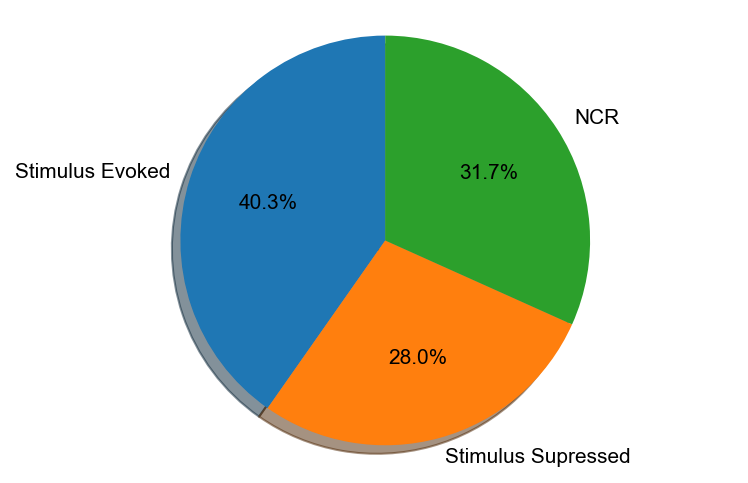

In [11]:
labels = 'Stimulus Evoked', 'Stimulus Supressed', 'NCR'
sizes = [stim_ev,stim_sup,NCR]
explode = (0, 0, 0)

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio
#fig.savefig(os.path.join('D:\\\\Figures','Population Statistics','Overall population statistics pie chart.pdf'),transparent=False,facecolor="white")